In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.io import *
from fastai.conv_learner import *
from fastai.text import *
from fastai.column_data import *

In [2]:
# from fsm import *

In [3]:
DATA_PATH = Path('data')
DATA_PATH
TMP_PATH = DATA_PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)

In [4]:
sql_ids = np.load(TMP_PATH/'sql_ids.npy')
sql_itos = pickle.load(open(TMP_PATH/'sql_itos.pkl','rb'))
sql_stoi =  collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(sql_itos)})

In [5]:
# fsm = Rule_Parse_FSM()
# get_next_random("select userid from users where ".split())
# get_next_random_fsm("select userid from users where ".split(), fsm)

## Setup

Set up directory path

In [6]:
dataset = pd.read_json(DATA_PATH/'train.json')
dataset.head(1)


,comments,description,id,sql,sql_plain,title,url
0,[],,586912,"SELECT p.Title,p.score,p.ViewCount,p.AnswerCou...","SELECT \np.Title,p.score,p.ViewCount,p.AnswerC...",Repent 151-160,http://data.stackexchange.com/stackoverflow/re...


In [7]:
# get_next_random("select userid from users where ".split())

SQL = dataset.sql
SQL = SQL.str.lower() # Pad space around non character string

In [8]:
SQL = SQL.str.replace('(\W)', r' \1 ')

In [9]:
SQL[:2]

0    select   p . title , p . score , p . viewcount...
1    create   table    # customerdb    (    id   in...
Name: sql, dtype: object

###  Weird Spacy

In [10]:
tmp =["id userid normal ac hed wed theyd  itd ID WED"]

In [11]:
Tokenizer.proc_all(tmp,lang='en') ## Seems confirm Jeremy's Theory

[['i',
  'd',
  'userid',
  'normal',
  'ac',
  'he',
  'd',
  'we',
  'd',
  'they',
  'd',
  'it',
  'd',
  'i',
  'd',
  't_up',
  'we',
  'd']]

## Parallel processing

In [12]:
def lambda_split(x):
    return x.split() 

In [13]:
def proc_all_mp(ss):
        ncpus = num_cpus()//2
        with ProcessPoolExecutor(ncpus) as e:
            return list(e.map(lambda_split, ss))

In [14]:
%time tmp = proc_all_mp(SQL)

CPU times: user 7.65 s, sys: 2.3 s, total: 9.95 s
Wall time: 8.06 s


In [15]:
%time [i.split() for i in SQL]
print("")

CPU times: user 214 ms, sys: 36 ms, total: 250 ms
Wall time: 249 ms



In [16]:
%time SQL.apply(lambda x : x.split())
print("")

CPU times: user 162 ms, sys: 19.6 ms, total: 182 ms
Wall time: 181 ms



In [17]:
%time SQL.str.split()
print("")

CPU times: user 326 ms, sys: 30.9 ms, total: 357 ms
Wall time: 356 ms



In [18]:
sql_tok = SQL.str.split()
" ".join(sql_tok[0])

'select p . title , p . score , p . viewcount , p . answercount , p . commentcount , len ( p . body ) as ques_size , p . favoritecount , p . id , u . reputation as user_repo , u . creationdate as user_join_date , datediff ( minute , p . creationdate , a . creationdate ) as qatimegap from posts as p , posts as a , users as u where p . id = a . parentid and p . owneruserid = u . id and a . creationdate = ( select min ( tau . creationdate ) from posts tau where tau . parentid = p . id group by tau . parentid ) and ( p . title like \' % recommended method for handling unsupportedencodingexception from string . getbytes ( " utf - 8 " ) % \' or p . title like \' % way to format strings with " ? " parameters to full string in java ? % \' or p . title like \' % how to parse a string without regular expressions % \' or p . title like \' % how to replace string only once without regex in java ? % \' or p . title like \' % efficiently removing specific characters ( some punctuation ) from strings

Clean up SQL that are too long/short.

In [19]:
lens=[len(i) for i in sql_tok]
lens= np.array(lens)

In [20]:
lens[:10]

array([316, 308,  24, 178,  44,  52,  84,  99, 190,  38])

In [21]:
lens.mean(),lens.min(),lens.max(),lens.std()

(83.80332601447508, 1, 863, 79.63395093587785)

(array([0.66122, 0.8905 , 0.95857, 0.98248, 0.99435, 0.99829, 0.99955, 0.9998 , 0.99992, 1.     ]),
 array([  1. ,  87.2, 173.4, 259.6, 345.8, 432. , 518.2, 604.4, 690.6, 776.8, 863. ]),
 <a list of 10 Patch objects>)

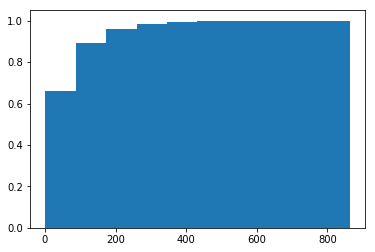

In [22]:
plt.hist(lens,cumulative=True,density=True)

In [23]:
tmp = len(sql_tok)
sql_tok = [i for i in sql_tok if len(i)>=4 and len(i)< int(lens.mean()+ 2*lens.std())] # Roughly 95% data
print('Filter out ', tmp - len(sql_tok), "sentences")

Filter out  1239 sentences


In [24]:
def toks2ids(tok,pre):
    freq = Counter(p for o in tok for p in o)
    itos = [o for o,c in freq.most_common()] ## Avoid rare tokens
    itos.insert(0, '_bos_')
    itos.insert(1, '_pad_')
    itos.insert(2, '_eos_')
    itos.insert(3, '_unk')
    stoi = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})
    ids = np.array([([0] + [stoi[o] for o in p] + [2]) for p in tok]) # pad bos at beginning and eos at the end
    np.save(TMP_PATH/f'{pre}_ids.npy', ids)
    pickle.dump(itos, open(TMP_PATH/f'{pre}_itos.pkl', 'wb'))
    return ids,itos,stoi

In [25]:
sql_ids,sql_itos,sql_stoi = toks2ids(sql_tok,'sql')

In [26]:
sql_ids_concat= []
for i in sql_ids:
    sql_ids_concat += i

In [27]:
len(sql_itos)

16288

In [28]:
sql_ids.shape

(23355,)

In [29]:
vocab_size = len(sql_itos)
print('total words:', vocab_size)

total words: 16288


### Create inputs

In [272]:
cs=16

c_in_dat = [[sql_ids_concat[i+j] for i in range(cs)] for j in range(0, len(sql_ids_concat)-cs-1, cs)]
c_out_dat = [[sql_ids_concat[i+j] for i in range(cs)] for j in range(1, len(sql_ids_concat)-cs, cs)]

xs = np.stack(c_in_dat)
ys = np.stack(c_out_dat)

In [31]:
xs.shape,ys.shape

((106545, 16), (106545, 16))

In [32]:
xs[:3]

array([[  0,  12,  11,  13, 103,  19,  90,   6, 104,   7,  35,   8,  22, 497,  22, 123],
       [ 22,   8,  24,  18, 121,   6, 104,   7, 114,   2,   0,  76,  31,  13, 146,   9],
       [140,   6, 146,   5,   8,  14,  14, 237, 125, 194,  39, 330,  39, 100,  14,  14]])

In [33]:
ys[:3]

array([[ 12,  11,  13, 103,  19,  90,   6, 104,   7,  35,   8,  22, 497,  22, 123,  22],
       [  8,  24,  18, 121,   6, 104,   7, 114,   2,   0,  76,  31,  13, 146,   9, 140],
       [  6, 146,   5,   8,  14,  14, 237, 125, 194,  39, 330,  39, 100,  14,  14,   8]])

In [34]:
bs=256

In [35]:
val_idx = get_cv_idxs(len(xs)-cs-1)
md = ColumnarModelData.from_arrays('.', val_idx, xs, ys, bs=bs)

## Model

In [36]:
import pdb

In [37]:
n_hidden=256
n_fac=128
dropout=0.5
bidir=True

In [38]:
class CharSeqStatefulGRU(nn.Module):
    def __init__(self, vocab_size, n_fac, bs):
        super().__init__()
        self.vocab_size = vocab_size
        self.e = nn.Embedding(vocab_size, n_fac)
        self.rnn1 = nn.GRU(n_fac, n_hidden, num_layers=2, dropout=dropout, bidirectional=bidir)
        self.l_out = nn.Linear(n_hidden+n_hidden*bidir, vocab_size)
        self.init_hidden(bs)
        
    def forward(self, *cs):
        bs = cs[0].size(0)
        if self.h1.size(1) != bs: self.init_hidden(bs)
        inp = self.e(torch.stack(cs))
        outp,h1 = self.rnn1(inp, self.h1)
        self.h1 = repackage_var(h1)
        #pdb.set_trace()
        return F.log_softmax(self.l_out(outp), dim=-1)
    
    def init_hidden(self, bs): 
        self.h1 = V(torch.zeros(2*bidir+2, bs, n_hidden))
       

In [39]:
torch.Tensor(2,10,100).transpose(0,1).contiguous().view(-1)


 4.2039e-44
 0.0000e+00
 9.8091e-44
     ⋮     
 3.0833e-41
 1.1210e-44
 0.0000e+00
[torch.FloatTensor of size 2000]

In [40]:
def nll_loss_seq(inp, targ):
    sl,bs,nh = inp.size()
    targ = targ.transpose(0,1).contiguous().view(-1)
    targ = targ.view(-1)
    return F.nll_loss(inp.view(-1,nh), targ)

In [41]:
print('n_hidden:',n_hidden,'n_fac:',n_fac,'bidir:',bidir,'dropout:',dropout)
            
m = CharSeqStatefulGRU(len(sql_itos), n_fac, bs=bs)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
learn = RNN_Learner(md, SingleModel(to_gpu(m)), opt_fn=opt_fn)
learn.crit = nll_loss_seq

n_hidden: 256 n_fac: 128 bidir: True dropout: 0.5


In [42]:
def accuracy(preds, targs):
    preds = torch.max(preds.view(-1,len(sql_itos)), dim=1)[1]
    targs = targs.transpose(0,1).contiguous().view(-1)
    return (preds==targs).float().mean()

In [43]:
learn.metrics = [accuracy]

In [44]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 69%|██████▉   | 229/333 [00:35<00:16,  6.41it/s, loss=7.79]

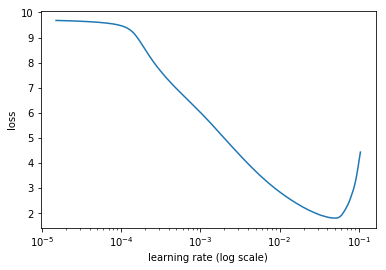

In [45]:
learn.sched.plot()

In [46]:
learn.fit(1e-4, 1, cycle_len=1,use_clr_beta = (5,10,0.95,0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  8%|▊         | 25/333 [00:03<00:47,  6.47it/s, loss=9.63]

Exception in thread Thread-5:
Traceback (most recent call last):
  File "/home/channoklam_cnl/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/channoklam_cnl/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/channoklam_cnl/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                   
    0      3.915841   3.71871    0.365472  



[array([3.71871]), 0.365471720338791]

# Run some test to generate some sentence at each training stage

In [54]:
def get_next(inp):
    idxs = T(np.array([sql_stoi[c] for c in inp]))
    p = m(*VV(idxs))
    p = to_np(p)
    i = np.argmax(p[-1,:,:],2)
    
    return sql_itos[i]

def get_next_random(inp):
    idxs = T(np.array([sql_stoi[c] for c in inp]))
    p = m(*VV(idxs))
    p = to_np(p)[0]
    pi = p.argsort()[-10:] # Sample the 10 most possible token only
    i = np.random.choice(pi, p=softmax_np(p[pi]))
    return sql_itos[i]

def softmax_np (nparray):
    ans = np.exp(nparray)
    return ans/ans.sum()



def get_sentence(inp):
    sentence = inp
    counter = 0
    tmp = []
    while "_eos_" not in tmp:   
        tmp = get_next(sentence[-cs:]) 
        sentence += [tmp]
        counter = counter+1
        if counter> 500:
            break
    return sentence

def get_sentence_random(inp):
    sentence = inp
    counter = 0
    tmp = []
    while "_eos_" not in tmp:   
        tmp = get_next_random(sentence[-cs:]) 
        sentence += [tmp]
        counter = counter+1
        if counter> 100:
            break
    return sentence

In [144]:
def test_case():
    sample = ['update','select','delete','insert']
    
    for i in sample:
        print('Input:', i, 'output:', i + " " + get_next(i))
              
             
    for i in sample:
        print('Input:', i, 'output:', get_sentence([i]))    
    print('For Random Generation')
      
    for i in sample:
        print('Input:', i, 'output:', i + " " + get_next_random(i))
                         
    for i in sample:
        print('Input:', i, 'output:', get_sentence_random([i]))    

In [145]:
test_case()

Input: update output: update on
Input: select output: select on
Input: delete output: delete on
Input: insert output: insert d
Input: update output: ['update', 'i', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'i', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'i', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'i', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'i', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'i', 'update', 

Input: insert output: ['insert', 'into', 'insert', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'into', 'insert', 'into', '

IndexError: index 2512 is out of bounds for axis 0 with size 1

In [50]:
learn.fit(1e-3, 1, cycle_len=1,use_clr_beta = (5,10,0.95,0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.715398   0.639467   0.909927  



[array([0.63947]), 0.9099272468956779]

In [51]:
test_case()

Input: update output: update .
Input: select output: select .
Input: delete output: delete on
Input: insert output: insert (
Input: update output: ['update', 'i', '_eos_']
Input: select output: ['select', 'top', 'select', 'top', 'select', 'top', 'select', 'top', 'select', 'top', 'select', 'top', 'select', 'top', 'select', 'top', 'select', 'top', '100', '*', 'top', 'select', 'top', 'select', 'top', 'select', 'top', 'select', 'top', 'select', 'top', 'select', 'top', 'select', 'top', '100', '*', 'top', 'select', 'top', 'select', 'top', 'select', 'top', 'select', 'top', 'select', 'top', 'select', 'top', 'select', 'top', '100', '*', 'top', 'select', 'top', 'select', 'top', 'select', 'top', 'select', 'top', 'select', 'top', 'select', 'top', 'select', 'top', '100', '*', 'top', 'select', 'top', 'select', 'top', 'select', 'top', 'select', 'top', 'select', 'top', 'select', 'top', 'select', 'top', '100', '*', 'top', 'select', 'top', 'select', 'top', 'select', 'top', 'select', 'top', 'select', 'to

In [52]:
learn.fit(1e-3, 1, cycle_len=3,use_clr_beta = (5,10,0.95,0.85))

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                    
    0      0.528536   0.482446   0.930122  
    1      0.382462   0.382661   0.943244                    
    2      0.320223   0.360264   0.947257                    



[array([0.36026]), 0.9472570996613492]

In [55]:
test_case()

Input: update output: update cross
Input: select output: select on
Input: delete output: delete on
Input: insert output: insert d
Input: update output: ['update', 'i', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'i', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'i', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'i', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'i', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'i', 'update

Input: delete output: ['delete', 'into', 'into', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'into', 'into', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'into', 'into', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'into', 'into', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'into', 'into', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'into', 'into', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', 'delete', '

In [146]:
tmp = iter(md.trn_dl)
*xxs,yt = next(tmp)

yt.shape

## Test Sentence

In [263]:
test_case()

Input: update output: update as
Input: select output: select t
Input: delete output: delete on
Input: insert output: insert d
Input: update output: ['update', 'i', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'i', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'i', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'i', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'i', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'update', 'i', 'update', '

Input: insert output: ['insert', 'into', 'insert', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'insert', 'into', 'into', 'insert', 'into', '

IndexError: index 2512 is out of bounds for axis 0 with size 1

In [301]:
print('Input:', " ".join([sql_itos[i] for i in np.array(xs[0])]))
print('Output:', " ".join([sql_itos[i] for i in  np.array(ys[0])]))
p = m(*VV(T(np.array(xs[0]))))
print('prediction:', " ".join([sql_itos[i] for i in to_np(torch.max(p.view(-1,len(sql_itos)),dim=1)[1])]))
print('next:', " ".join([sql_itos[i] for i in np.array(xs[1])]))

Input: _bos_ select id from comments where lower ( text ) like ' % accept % answer
Output: select id from comments where lower ( text ) like ' % accept % answer %
prediction: select id from comments where lower ( text ) like ' % accept % answer %
next: % ' order by len ( text ) asc _eos_ _bos_ declare @ from datetime =


In [289]:
??accuracy

In [290]:
np.array(xs[0]),np.array(ys[0])

(array([  0,  12,  11,  13, 103,  19,  90,   6, 104,   7,  35,   8,  22, 497,  22, 123]),
 array([ 12,  11,  13, 103,  19,  90,   6, 104,   7,  35,   8,  22, 497,  22, 123,  22]))

In [91]:
# def get_next_random_fsm(inp, fsm):
#     idxs = T(np.array([char_indices[c] for c in inp]))
#     p = m(*VV(idxs))
#     p = to_np(p)[0]
#     pi = p.argsort()[-10:]
#     i = np.random.choice(pi, p=softmax_np(p[pi]))
    
#     if fsm.run(indices_char[i]):
#         return indice_char[i]
#     else: 
#         for pii in pi:
#             if fsm.run(indice_char[pii]):
#                 print('pii loop')
#                 return indice_char[pii]
#             else:
#                 print('Error, no valid words at all')  
    
    
#     return "ERROR"

# fsm = Rule_Parse_FSM()

# get_next_random("select userid from users where ".split())

# get_next_random_fsm("select userid from users where ".split(), fsm)

NameError: name 'Rule_Parse_FSM' is not defined